## _*Comparing Strings with Quantum Superpositon*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q Experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).


***
### Contributors
Rudy Raymond

## Motivation

If we can use quantum states to represent genetic codes, we may be able to compare them, and/or find similar genetic codes quickly. 

For example, according to [this site](http://www.bioinformatics.org/sms2/genetic_code.html) the starts of the genetic codes for the Yeast Mitochondrial, Protozoan Mitochondrial, and Bacterial Code are respectively as follow. 

In [10]:
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"

YEAST     = "0000"
PROTOZOAN = "1111"
BACTERIAL = "0101"

Notice that each of the codes is represented by a bitstring of length 64. By comparing characters at the same position in the strings, we can see that Protozoan's is closer to Bacterial's than Yeast's. 

Exploiting quantum superposition, we can create quantum states by using only 7 qubits such that each of the quantum states corresponds to the genetic code of Yeast, Protozoan, and Bacterial. We then compare the closeness of their genetic codes by comparing their quantum states by making use of the reversibility of quantum circuit.

The reversibility of quantum circuit to test the similarity of quantum states works as follow. Assume that we can create a quantum superposition starting from all-zero states by a quantum circuit. Then by inverting the same quantum circuit and we give it the same quantum superposition as input, we will get exactly all-zero bits as the output. Now, when we give a similar quantum superposition as input to the inverted circuit, we can still get all-zero bits as the output with probability proportional to the similarity of the quantum states: the more similar, the more we observe all-zero bits. 

Thus, to decide which code (Yeast's or Bacterial's) is the most similar to the Protozoan, we can do the following:

1. We first prepare the quantum state that encodes the Protozoan's
2. We then use the quantum state as inputs to the inverted circuits that each prepare the quantum state of Yeast's and Bacterial's. Run and measure the circuits
3. Output the name of the inverted circuit whose measurements result in more number of all-zero bits. 


## Quantum Superposition for Bitstring

A qubit can be in a superposition of two basis states: "0" and "1" at the same time. Going further, two qubits can be in a superposition of four basis states: "00", "01", "10", and "11". In general, $n$ qubits can be in a superposition of $2^n$ (exponential in the number of qubits!) basis states. 

Here, we show a simple example to create quantum superpositon for bitstrings and use them to compare the similarity between two bitstrings. This tutorial makes use the [quantum state initialization function](https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/reference/tools/quantum_gates_and_linear_algebra.ipynb#Arbitrary-initialization). It also illustrates the power of loading data into quantum states. 

## Comparing bitstrings of length 64 with 7 qubits

Let say we have three genetic codes as above.

```
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"
```

Let use 7 qubits to encode the above codes: the first 6 qubits for indexing the location in the code (because we have 64 positions that we number from 0 to 63), and the last qubit for the content of the code (we use "0" for "-" and "1" for "M"). Thus, numbering the position of the code from left to right, we can create quantum states for each of the code as below: 

\begin{eqnarray}
|{\mbox{YEAST}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle  + |000010\rangle |0\rangle + |000011\rangle |0\rangle + \ldots \right) \\
|{\mbox{PROTOZOAN}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |1\rangle + |000011\rangle |1\rangle + \ldots \right) \\
|{\mbox{BACTERIAL}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |0\rangle + |000011\rangle |1\rangle + \ldots \right)
\end{eqnarray}

The first four codes of Yeast's are all "-", and therefore at the above all of the second registers of the corresponding state are "0". And so on. 

### Creating quantum superposition for genetic codes

Below is the python function to create a quantum superposition for a given genetic code as above. 

In [29]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import CompositeGate

def encode_bitstring(bitstring, qr, cr, inverse=False):
    """
    create a circuit for constructing the quantum superposition of the bitstring
    """
    n = math.ceil(math.log2(len(bitstring))) + 1                 #number of qubits
    assert n > 2, "the length of bitstring must be at least 2"
    
    #prepare quantum registers
    #qr = QuantumRegister(n)
    #classical registers for measurement
    #cr = ClassicalRegister(n)
    #quantum circuit
    qc = QuantumCircuit(qr, cr)
    
    #the probability amplitude of the desired state
    desired_vector = np.array([ 0.0 for i in range(2**n) ])     #initialize to zero
    amplitude = np.sqrt(1.0/2**(n-1))
    
    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1" or b == "M":
            pos += 1
            print("M/1", pos)
        desired_vector[pos] = amplitude
    if not inverse:
        qc.initialize(desired_vector, [ qr[i] for i in range(n) ] )
        qc.barrier(qr)
    else:
        qc.initialize(desired_vector, [ qr[i] for i in range(n) ] ).inverse()  #invert the circuit
        #for i in range(n):
        #    qc.measure(qr[i], cr[i])
    print()
    return qc

We can now create quantum circuits to create the quantum states for the Yeast's, Protozoan's, and Bacterial's.

In [30]:
n = math.ceil(math.log2(len(YEAST))) + 1                 #number of qubits
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

qc_yeast     = encode_bitstring(YEAST, qr, cr)
qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr)
qc_bacterial = encode_bitstring(BACTERIAL, qr, cr)

circs = {"YEAST": qc_yeast, "PROTOZOAN": qc_protozoan, "BACTERIAL": qc_bacterial}


M/1 1
M/1 3
M/1 5
M/1 7

M/1 3
M/1 7



### Inversing quantum circuit

We can easily inverse a quantum circuit by `inverse()` function. These inverse circuits are desirable to compute the closeness of the quantum states. The intuition 

In [31]:
inverse_qc_yeast     = encode_bitstring(YEAST,     qr, cr, inverse=True)
inverse_qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr, inverse=True)
inverse_qc_bacterial = encode_bitstring(BACTERIAL, qr, cr, inverse=True)

inverse_circs = {"YEAST": inverse_qc_yeast, "PROTOZOAN": inverse_qc_protozoan, "BACTERIAL": inverse_qc_bacterial}


M/1 1
M/1 3
M/1 5
M/1 7

M/1 3
M/1 7



### Comparing bitsrings

We can now compare how close the starts of the genetic codes of Protozoan to Yeast's and Bacterial's by performing the test.

In [32]:
#to run quantum circuits
from qiskit import execute, register, available_backends
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

try:
    sys.path.append("../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"d05e9f4bd7c3c44abc479d5024349ae556b78df9dd26fc09bdae0ab12e432fd29da1ac218d0513408764fce1182d404de91e1fa4ca3f59c17da9ae5615e159e2",
        "url":"https://quantumexperience.ng.bluemix.net/api"}
#register token to connect with remote backends
register(qx_config['APItoken'], qx_config['url'])
print(available_backends())

def norm(state1, state2):
    return abs(np.dot(np.array(state1).conj(), state2))**2

key = "PROTOZOAN"       #the name of the code used as key to find similar ones

# use local simulator
#backend = "local_qasm_simulator"
# use remote simulator
#backend = "ibmq_qasm_simulator"
# use statevector
backend = "local_statevector_simulator"
# the number of shots is twice the length of the bitstring
shots = 1000

combined_circs = {}
count = {}

job = execute(circs[key], backend=backend)
ref_state = job.result().get_statevector(circs[key])

for k in inverse_circs:
    _ = inverse_circs[k] + circs[key]
    job = execute(_ , backend=backend)
    tar_state = job.result().get_statevector(_)
    print(key, k, tar_state)
    #print(key, k, norm(ref_state, tar_state))

"""
for other_key in inverse_circs:
    
    if other_key == key:
        continue
    combined_circs[other_key] = circs[key] #+ inverse_circs[other_key]   #combined circuits to look for similar codes
    #count[other_key] = execute(combined_circs[other_key], backend=backend, shots=shots).result().get_counts()
    job = execute(combined_circs[other_key], backend=backend)
    st = job.result().get_statevector(combined_circs[other_key])
    print(st)
    #print(key, "vs.", other_key, ":", count[other_key])
    #plot_histogram(result[other_key].get_counts())
"""

['local_qasm_simulator', 'local_clifford_simulator', 'ibmqx5', 'ibmqx4', 'ibmqx2', 'ibmq_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']
PROTOZOAN YEAST [ 6.12323400e-17+0.j -1.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  6.16297582e-33+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j]
PROTOZOAN PROTOZOAN [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
PROTOZOAN BACTERIAL [ 5.00000000e-01+0.j -5.00000000e-01+0.j  5.00000000e-01+0.j
  5.00000000e-01+0.j  0.00000000e+00+0.j -5.55111512e-17+0.j
  0.00000000e+00+0.j -5.55111512e-17+0.j]


'\nfor other_key in inverse_circs:\n    \n    if other_key == key:\n        continue\n    combined_circs[other_key] = circs[key] #+ inverse_circs[other_key]   #combined circuits to look for similar codes\n    #count[other_key] = execute(combined_circs[other_key], backend=backend, shots=shots).result().get_counts()\n    job = execute(combined_circs[other_key], backend=backend)\n    st = job.result().get_statevector(combined_circs[other_key])\n    print(st)\n    #print(key, "vs.", other_key, ":", count[other_key])\n    #plot_histogram(result[other_key].get_counts())\n'

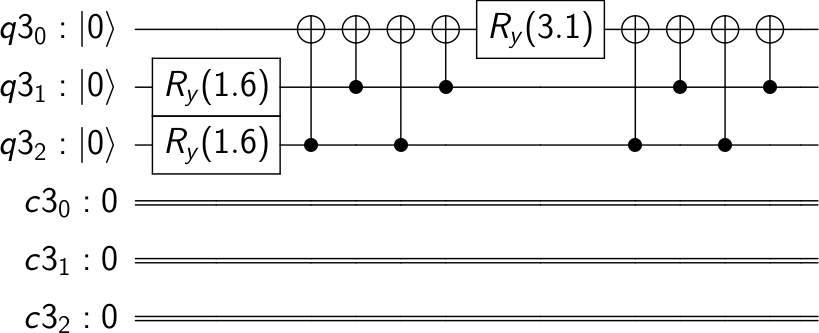

In [33]:
#draw the circuit
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circs["PROTOZOAN"])

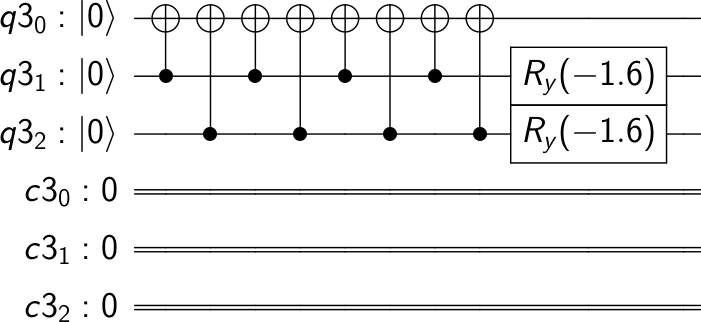

In [34]:
circuit_drawer(inverse_circs["YEAST"])

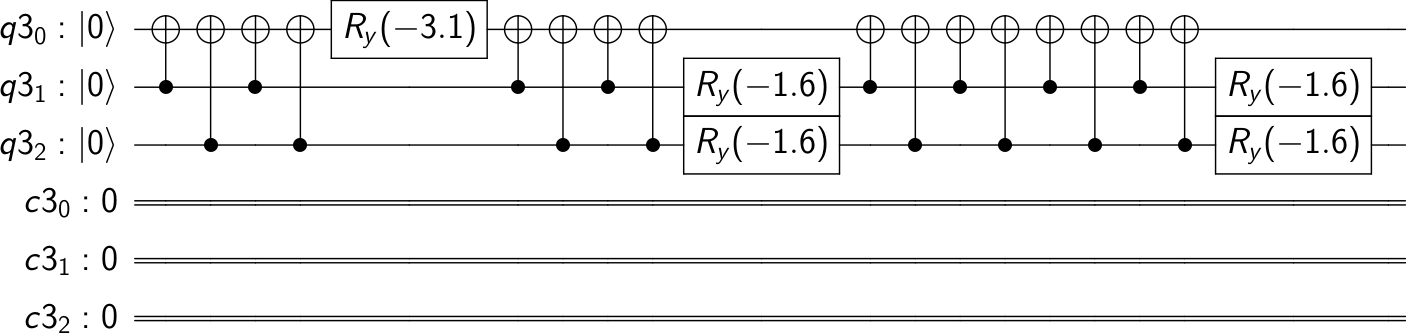

In [35]:
circuit_drawer(circs["PROTOZOAN"].combine(circs["YEAST"]))

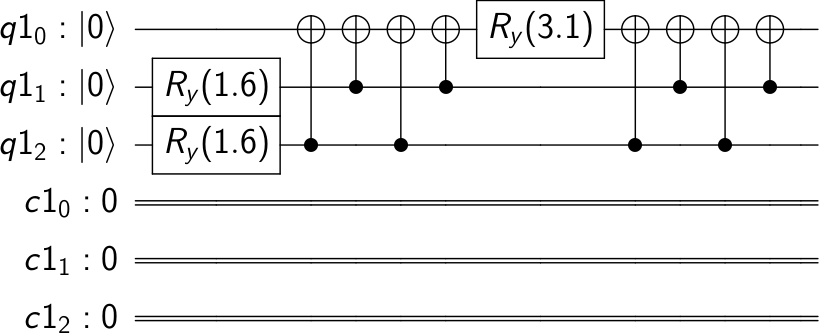

In [29]:
circuit_drawer(inverse_circs["YEAST"] + circs["PROTOZOAN"])

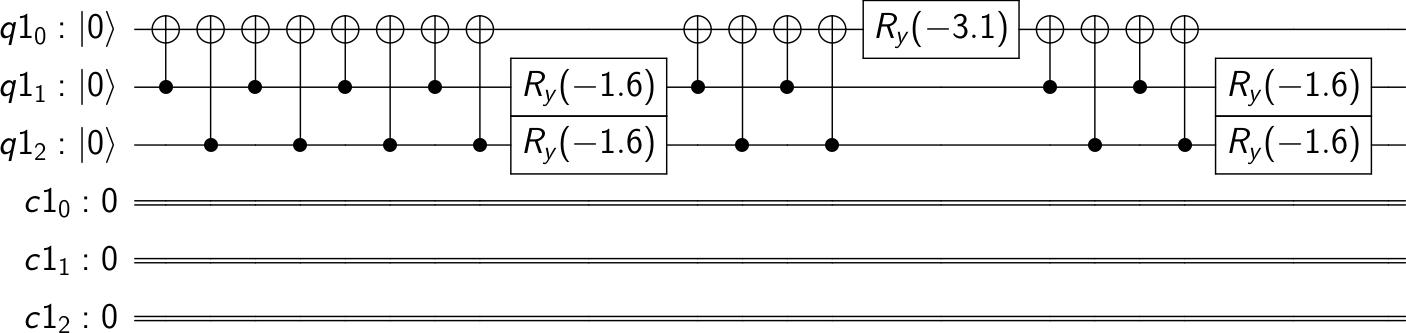

In [30]:
circuit_drawer(circs["YEAST"] + circs["PROTOZOAN"])

In [ ]:
from qiskit.tools.visualization import plot_histogram

qp = QuantumProgram()
q = qp.create_quantum_register("q", 1)
c = qp.create_classical_register("c", 1)
qc1Error = qp.create_circuit("H1", [q], [c])
qc1Error.initialize([1.0/np.sqrt(2), 1.0/np.sqrt(2)], [ q[0] ]).inverse() #I can inverse the initialization!!!
qc1Error.x(q)

qc2Error = qp.create_circuit("H2", [q], [c])
qc2Error.initialize([1.0/np.sqrt(2), -1.0/np.sqrt(2)], [ q[0] ])
qc2Error.h(q)

qp.add_circuit("H1_and_H2", qc1Error + qc2Error) 


## set up program
#qp1 = QuantumProgram()
#
#qp1.add_circuit("s1_and_s3", qc_for_q1 + qc_for_q3)
#
#qp2 = QuantumProgram()
#qp2.add_circuit("s2", qc_for_q2)
#
#qp3 = QuantumProgram()
#qp3.add_circuit("s3", qc_for_q3)
#
#backend = "local_qiskit_simulator" 
#shots_sim = 1000
#
#qp = QuantumProgram()
#qp.add_circuit("s1_barrier_s1", qp1 + qp2)
#results_sim = qp.execute(["s1_barrier_s1"], backend=backend, shots = shots_sim)
#stats_sim = results_sim.get_counts("s1_barrier_s1")
#
#plot_histogram(stats_sim)

In [ ]:
circuit_drawer(qc1Error)

In [ ]:
circuit_drawer(qc1Error.reverse())

In [ ]:
circuit_drawer(qc1Error)

In [ ]:
circuit_drawer(qc2Error)

In [ ]:
circuit_drawer(qp.get_circuit("H1_and_H2"))

The above results in *stats* tell us how many times each bit string was found as a result. To make our emoticon, we convert the bit strings into ASCII characters. We also calculate the fraction of shots for which each result occurred. The most common results are then printed to screen.

This gives us a list of characters and probabilities. But that isn't very fun. For something more visual, we use matplotlib to create an image in which the all the characters included in the result are printed on top of each other. The alpha channel of each character is set to the fraction of shots for which that result occurred. For our simulator results, this is approximately equally split between 8) and ;).

We will write this transformation and visualization from results to ASCII characters as a function, so we can reuse it later when we run the smiley circuit on the *ibmqx5* device. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='monospace')

def plot_smiley (stats, shots):
    for bitString in stats:
        char = chr(int( bitString[0:8] ,2)) # get string of the leftmost 8 bits and convert to an ASCII character
        char += chr(int( bitString[8:16] ,2)) # do the same for string of rightmost 8 bits, and add it to the previous character
        prob = stats[bitString] / shots # fraction of shots for which this result occurred
        # create plot with all characters on top of each other with alpha given by how often it turned up in the output
        plt.annotate( char, (0.5,0.5), va="center", ha="center", color = (0,0,0, prob ), size = 300)
        if (prob>0.05): # list prob and char for the dominant results (occurred for more than 5% of shots)
            print(str(prob)+"\t"+char)
    plt.axis('off')
    plt.show()
    
plot_smiley(stats_sim, shots_sim)

We'll now run the smiley circuit on *ibmqx5*, after checking that the device is online. Given the noise on the device, our smiley won't be as clean as our previous run on the simulator.

In [ ]:
backend = "ibmqx5"

if get_backend_instance(backend).status["available"] is True:
    shots_device = 1000
    results_device = qp.execute(["smiley_writer"], backend=backend, shots=shots_device, wait=5, timeout=300)
    stats_device = results_device.get_counts("smiley_writer")
    plot_smiley(stats_device, shots_device)

And there you have it. A program to take one of the world's most advanced devices and made a smiley with it. A quantum smiley!

An alternative introduction to this program can be found [here](https://medium.com/@decodoku/making-a-quantum-computer-smile-cee86a6fc1de).

In [ ]:
print("Installed packages are as the following")
!python --version
print()
!conda list 'qiskit|IBMQuantumExperience|numpy|scipy|matplotlib'

In [ ]:

#To prepare the programming environment

# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import QuantumProgram
from qiskit.backends import discover_local_backends, discover_remote_backends
from qiskit.tools.visualization import circuit_drawer

qp = QuantumProgram()
q = qp.create_quantum_register("q", 3)
#c = qp.create_quantum_register("c", 3)
mainCircuit = qp.create_circuit("main", [q])
def encode_bitstring(bitstring, q):
    #create a circuit for representing the bitstring in a quantum superposition
    n = math.ceil(math.log2(len(bitstring))) + 1
    #print("n=", n)
    assert n > 2, "the length of bitstring must be at least 2"
    #q = QuantumRegister("q", n)
    #c = ClassicalRegister("c", n)
    qc = qp.create_circuit(bitstring, [q])
    desired_vector = np.array([ 0.0 for i in range(2**n) ])
    amplitude = np.sqrt(1.0/2**(n-1))
    
    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1":
            pos += 1
        desired_vector[pos] = amplitude
    #print("desired vector = ", desired_vector)
    qc.initialize(desired_vector, [ q[i] for i in range(n) ] )
    qc.barrier(q)
    return qc